# Стратегия взаимодействия с клиентами фитнес-центра

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 
Необходимо провести анализ и подготовить план действий по удержанию клиентов (на основе информации об оттоке клиентов).

В нашем распоряжении файл на основе клиентских анкет, содержащий данные пользователей фитнес-центра на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

•	Данные клиента за предыдущий до проверки факта оттока месяц:
*	'gender' — пол;
*	'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
*	'Partner' — сотрудник компании-партнёра клуба;
*	Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
*	'Phone' — наличие контактного телефона;
*	'Age' — возраст;
*	'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

•	Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
*	'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
*	'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
*	'Group_visits' — факт посещения групповых занятий;
*	'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
*	'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
*	'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

•	'Churn' — факт оттока в текущем месяце.

**Цель исследования**:
* Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* Проанализировать основные признаки, наиболее сильно влияющие на отток;
* Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
	* 1) выделить целевые группы клиентов;
	* 2) предложить меры по снижению оттока;
	* 3) определить другие особенности взаимодействия с клиентами.

**Оглавление проекта**
1. [Исследовательский анализ данных](#analysis)
    * 1.1. [Ознакомление с датасетом](#analysis_1)
    * 1.2. [Средние значения признаков по группам](#analysis_2)
    * 1.3. [Столбчатые гистограммы и распределения признаков по группам](#analysis_3)
    * 1.4. [Матрица корреляций](#analysis_4)
    * 1.5. [Вывод по данным](#conclusion_1)
2. [Модель прогнозирования оттока клиентов](#model)
    * 2.1. [Разбиение на выборки](#model_1)
    * 2.2. [Обучение моделей](#model_2)
    * 2.3. [Оценка метрик на валидационной выборке](#model_3)
    * 2.4. [Вывод по моделям](#conclusion_2)
3. [Кластеризация клиентов](#cluster)
    * 3.1. [Стандартизация данных](#cluster_1)
    * 3.2. [Матрица расстояний и дендрограмма](#cluster_2)
    * 3.3. [Обучение модели кластеризации](#cluster_3)
    * 3.4. [Средние значения признаков для кластеров и доли оттока](#cluster_4)
    * 3.5. [Распределения признаков для кластеров](#cluster_5)
4. [Выводы и рекомендации](#conclusion)

## Исследовательский анализ данных
<a id="analysis"></a>
Импортируем нужные библиотеки и загрузим данные.

In [1]:
# импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [2]:
# загрузка данных с возможностью открывать файл локально
path = 'C:/Data/'

try:
    data = pd.read_csv('/datasets/gym_churn.csv')
except:
    data = pd.read_csv(path + 'gym_churn.csv')

### Ознакомление с датасетом
<a id="analysis_1"></a>

In [3]:
display(data)
data.info()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Преобразуем названия колонок к нижнему регистру

In [4]:
columns_before = data.columns
columns_after = data.columns.str.lower()
columns_after

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [5]:
for i in range(14):
    data = data.rename(columns={columns_before[i]: columns_after[i]})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [6]:
# вывод описательной статистики
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Из таблицы можно сделать выводы, что в большей массе клиенты оставляют свой номер телефона, живут где-то поблизости от клуба, 75% клиентов пришли относительно недавно (меньше или равно 5 мес.), отток за последний месяц составляет 26,5%. Смысла анализировать стандартное отклонение у бинарных признаков нет. По остальным можно сказать, что стандартное отклонение является небольшим только у признака age. У признаков  avg_additional_charges_total и lifetime при этом можно заметить max значения, похожие на выбросы.

In [7]:
# подсчёт явных дубликатов
data.duplicated().sum()

0

### Средние значения признаков по группам
<a id="analysis_2"></a>

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. Значения 0 - для тех, кто остался, и 1 - для тех, кто ушел.

In [8]:
data.groupby('churn').mean().round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.9,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.9,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


Можно выявить следующие наблюдения по средним значениям признаков:
1. Уходит меньше клиентов, сотрудников компаний-партнеров клуба;
2. Уходит меньше клиентов, пришедших по акции "приведи друга";
3. Клиенты чаще уходят, если срок договора небольшой;
4. Если клиент не ходит на групповые занятия, то вероятность, что он уйдет больше;
5. Клиенты, которые уходят, меньше тратили на дополнительные услуги клуба;
6. Клиенты чаще уходят, если до конца договора остается меньше 2-ух месяцев;
7. Клиенты чаще уходят если время с момента первого обращения в фитнес-центр около 1 месяца;
8. Клиенты чаще уходят, если средняя частота посещений в неделю менее 2 раз;
9. Клиенты чаще уходят, если средняя частота посещений в неделю за предыдущий месяц равна 1.

### Столбчатые гистограммы и распределения признаков по группам
<a id="analysis_3"></a>
Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

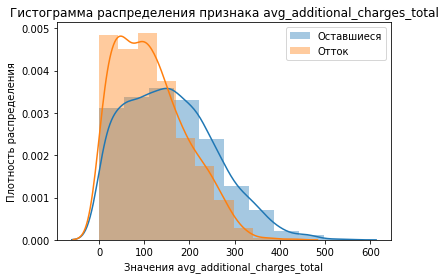

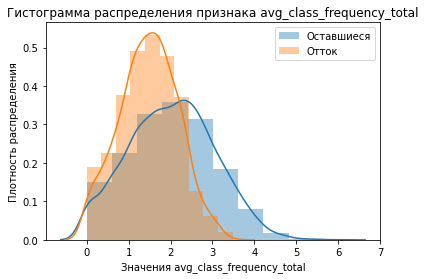

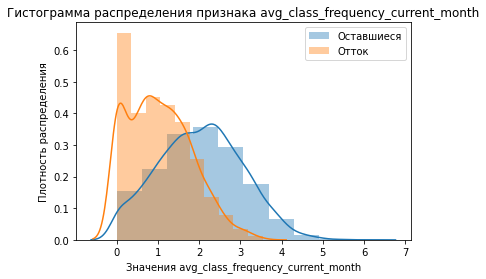

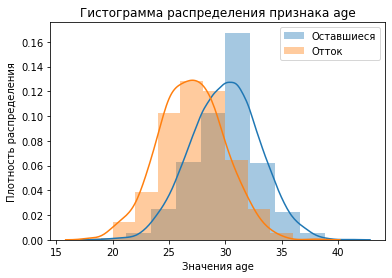

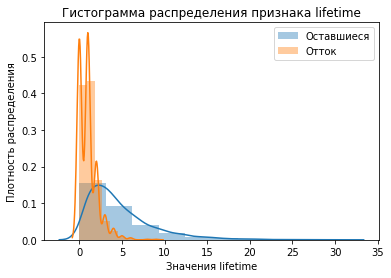

In [9]:
# выделяем датафреймы пользователей, которые остались клиентами и тех, что ушли (отток)
alive = data[data['churn']==0]
outflow = data[data['churn']==1]

# выделяем непрерывные величины в отдельный список
continuous = ['avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 
              'age', 'lifetime']

# строим гистограммы распределения для списка continuous
for feature in continuous:
    plt.title(f"Гистограмма распределения признака {feature}")
    sns.distplot(alive[feature], bins=10, label='Оставшиеся')
    sns.distplot(outflow[feature], bins=10, label='Отток')
    plt.xlabel(f"Значения {feature}")
    plt.ylabel('Плотность распределения')
    plt.legend()
    plt.show()

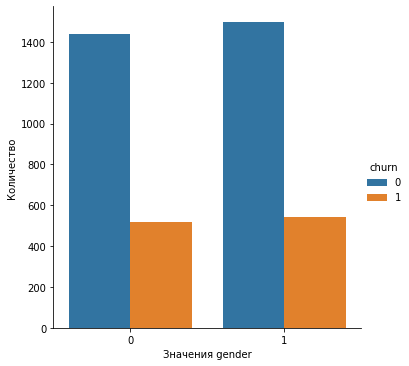

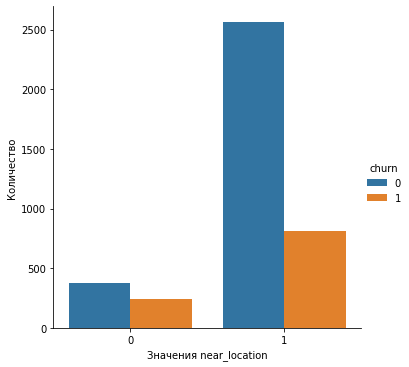

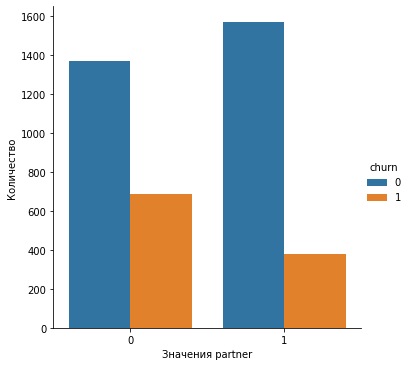

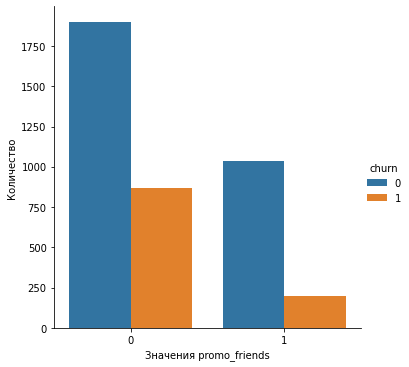

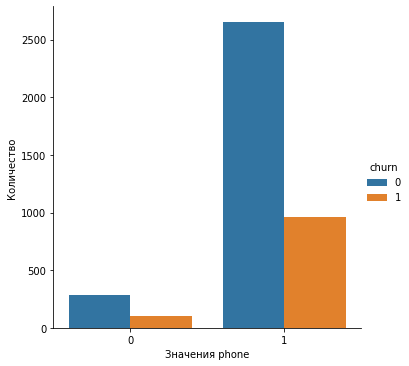

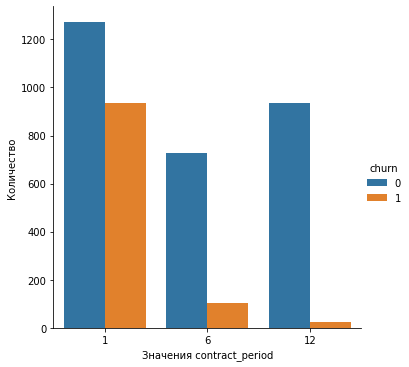

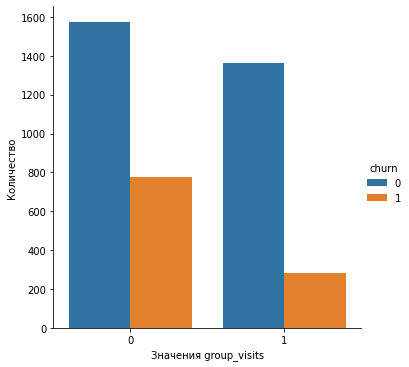

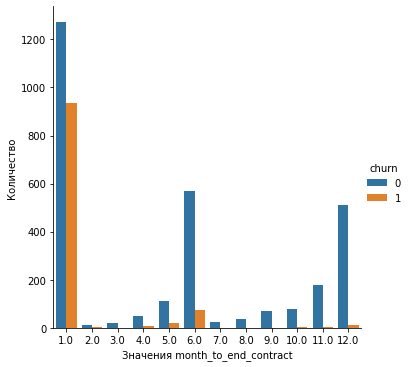

In [10]:
# выделяем дискретные величины в отдельный список
discrete = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits',
            'month_to_end_contract']

# строим столбчатые диаграммы для списка discrete
for feature in discrete:
    #sns.barplot(x=feature, y=data[feature].count(), hue='churn', data=data)
    sns.catplot(data=data, x=feature, hue='churn', kind='count')
    plt.xlabel(f"Значения {feature}")
    plt.ylabel('Количество')
    plt.show()

По графикам можно сделать аналогичные выводы, что и в предыдущем пункте. Плюс добавить, что к оттоку склонны более молодые люди (около 27 лет).

### Матрица корреляций
<a id="analysis_4"></a>
Построим матрицу корреляций и отобразим её.

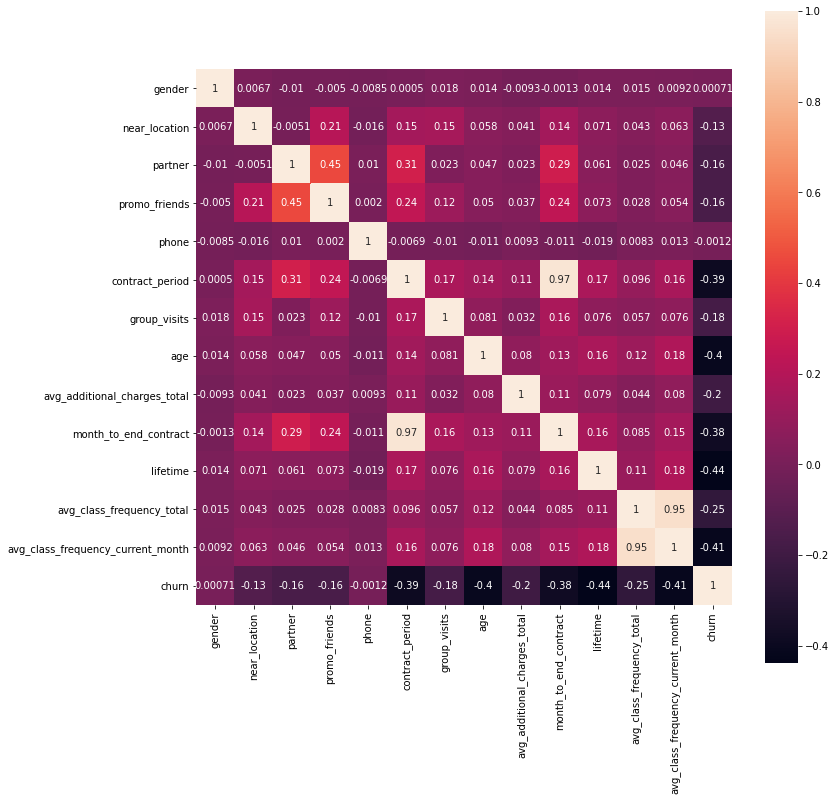

In [11]:
cm = data.corr()
fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(cm, annot=True, square=True)
ax.set_ylim(14, 0)
plt.show()

Видим сильную корреляцию следующих признаков: contract_period и month_to_end_contract, а также avg_class_frequency_total и avg_class_frequency_current_month. Нужно учитывать это, так как некоторые модели неустойчивы в случае взаимной корреляции признаков. Нужно будет либо избавиться от одного из двух признаков с большой корреляцией, либо использовать регуляризацию.

### Вывод по данным
<a id="conclusion_1"></a>

1. Пропущенных значений и дубликатов в таблице не наблюдается. Названия столбцов были приведены к нижнему регистру.
2. В большей массе клиенты оставляют свой номер телефона (90%), живут где-то поблизости от клуба (почти 85%), 75% клиентов пришли относительно недавно (5 мес. назад и меньше), отток за последний месяц составил 26,5%.  У признаков  avg_additional_charges_total и lifetime есть max значения, похожие на выбросы.
3. По средним значениям признаков и графикам в разрезе тех, кто остался, и тех, кто ушел, выяснили:
* Уходит меньше клиентов, сотрудников компаний-партнеров клуба и пришедших по акции "приведи друга";
* Клиенты чаще уходят, если срок договора небольшой и если до конца договора остается меньше 2-ух месяцев;
* Если клиент не ходит на групповые занятия, то вероятность, что он уйдет больше;
* Клиенты, которые уходят, меньше тратили на дополнительные услуги клуба;
* К оттоку склонны более молодые люди (около 27 лет);
* Клиенты чаще уходят если с момента первого обращения в фитнес-центр прошел 1 месяц и при средней частоте посещения 1-2 раза в неделю.
4. Есть сильная корреляция следующих признаков: contract_period и month_to_end_contract, а также avg_class_frequency_total и avg_class_frequency_current_month. Предлагается в модели использовать только month_to_end_contract и avg_class_frequency_current_month.

## Модель прогнозирования оттока клиентов
<a id="model"></a>
Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

In [12]:
# избавляемся от столбцов, которые мешают обучению модели
data.drop(['contract_period', 'avg_class_frequency_total'], axis=1, inplace=True)

### Разбиение на выборки
<a id="model_1"></a>
Разобьем данные на обучающую и валидационную выборку.

In [13]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(columns=['churn'])
y = data['churn']

# делим выборку на train и test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# применяем стандартизацию к матрице признаков для обучающей выборки
scaler = StandardScaler()
X_train_st = scaler.fit_transform(
    X_train
)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

###  Обучение моделей
<a id="model_2"></a>
Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом.

In [14]:
# задаем список моделей
models = [
    LogisticRegression(solver='liblinear', random_state=0),
    RandomForestClassifier(n_estimators = 100, random_state = 0),
]

# функция обучения
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred


### Оценка метрик на валидационной выборке
<a id="model_3"></a>
Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке.

In [15]:
# цикл, который выводит неоходимые метрики по списку моделей после вызова функции обучения и предсказания целевой переменной
for i in models:
    print(f"Метрики для {i}:")
    predictions = make_prediction(i, X_train_st, y_train, X_test_st, y_test)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
    

Метрики для LogisticRegression(random_state=0, solver='liblinear'):
Accuracy: 0.90
Precision: 0.79
Recall: 0.82
Метрики для RandomForestClassifier(random_state=0):
Accuracy: 0.91
Precision: 0.82
Recall: 0.78


За счет более высокого показателя доли правильных ответов и точности выбираем модель случайного леса.

Определим веса признаков для выбранной модели.

In [16]:
model = RandomForestClassifier(n_estimators = 100, random_state = 0)
model.fit(X_train_st, y_train)
predictions = model.predict(X_test_st)

# создадим датафрейм с признаками и их весами
features = pd.DataFrame({'feature': X.columns,
                   'importances': model.feature_importances_}) 

# выведим упорядоченный по модулю коэффициентов датафрейм с признаками
print(features.sort_values(by = 'importances', ascending = False))

                              feature  importances
9                            lifetime     0.321614
10  avg_class_frequency_current_month     0.209702
6                                 age     0.139873
7        avg_additional_charges_total     0.124591
8               month_to_end_contract     0.116619
5                        group_visits     0.019822
3                       promo_friends     0.016033
2                             partner     0.015954
0                              gender     0.015723
1                       near_location     0.011902
4                               phone     0.008165


### Вывод по моделям
<a id="conclusion_2"></a>
Модели логистической регрессии и случайного леса показали близкие результаты, но была выбрана модель случайного леса, у которой больше значения по двум метрикам (доля правильных ответов и точность). Определили, у каких признаков больше влияния на целевую переменную для выбранной модели, это: 
* lifetime (время с момента первого обращения в фитнес-центр), 
* avg_class_frequency_current_month (средняя частота посещений в неделю за предыдущий месяц), 
* age (возраст), 
* avg_additional_charges_total (суммарная выручка от других услуг),
* month_to_end_contract (срок до окончания абонемента).

## Кластеризация клиентов
<a id="cluster"></a>
Проведем кластеризацию объектов (клиентов).

### Стандартизация данных
<a id="cluster_1"></a>
Стандартизируем все данные, за исключением столбца с оттоком.

In [17]:
sc = StandardScaler()
# обучаем нормализатор и преобразуем набор данных к стандартизованному виду
x_sc = sc.fit_transform(data.drop(columns=['churn']))

### Матрица расстояний и дендрограмма
<a id="cluster_2"></a>
Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить.

In [18]:
# вычисляем матрицу расстояний между всеми объектами
linked = linkage(x_sc, method = 'ward')

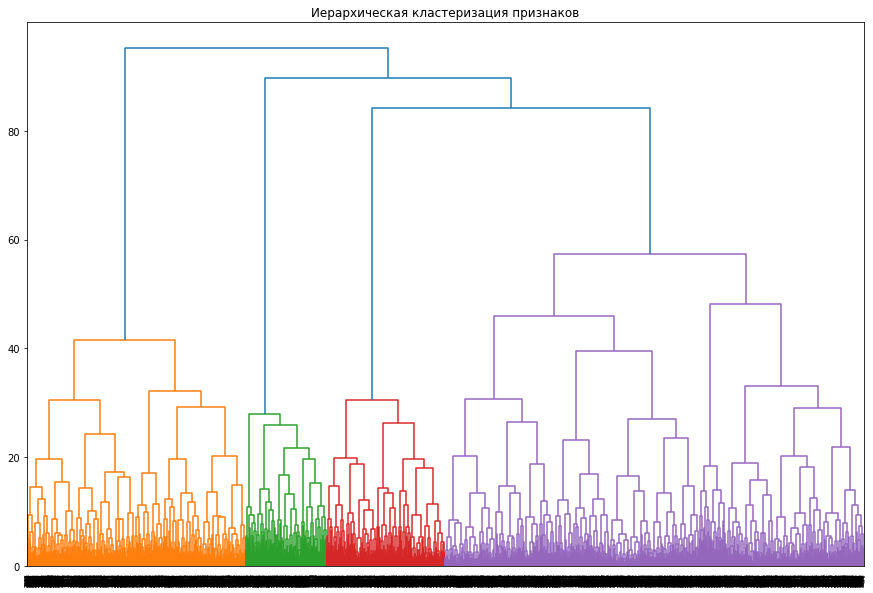

In [19]:
# строим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация признаков')
plt.show()

Судя по графику оптимальное число кластеров 4 — четыре разных цвета на графике. Но на фиолетовой ветке видно четко еще одно разделение, поэтому можно взять 5 кластеров.

### Обучение модели кластеризации
<a id="cluster_3"></a>
Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.За число кластеров принимаем n=5.

In [20]:
km = KMeans(n_clusters=5, random_state=0)
# применяем алгоритм к данным и формируем вектор кластеров (присваивание им номера от 0 до 4)
labels = km.fit_predict(x_sc) 

In [21]:
# сохраняем метки кластера в поле нашего исходного датасета
data['cluster'] = labels

### Средние значения признаков для кластеров и доли оттока
<a id="cluster_4"></a>
Посмотрим на средние значения признаков для кластеров и доли оттока по ним.

In [22]:
# выводим статистику по средним значениям наших признаков по кластеру
data.groupby('cluster').mean().round(2)

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,
0,0.49,0.99,0.95,1.00,0.91,0.53,29.63,154.09,6.73,4.29,1.92,0.11
1,0.50,1.00,0.38,0.05,0.90,0.00,30.34,174.39,4.70,5.17,2.24,0.05
2,0.51,1.00,0.23,0.11,0.90,0.18,26.81,111.07,1.72,1.42,0.98,0.74
3,0.50,0.00,0.49,0.07,0.91,0.23,28.70,137.38,2.83,3.03,1.60,0.40
4,0.55,1.00,0.27,0.08,0.90,1.00,30.25,155.21,4.71,4.48,2.04,0.09


Можно заметить следующее:
1. Самый большой отток по кластеру 2 (74%), в этом кластере самый молодой средний возраст, клиенты там меньше тратят на доп. услуги клуба, пришли в клуб недавно, договор на посещения закончится меньше чем через 2 мес., посещение в среднем 1 раз в неделю.
2. Следующий по оттоку кластер 3 (40%), люди которые живут не близко с клубом и ходят в клуб менее 2-ух раз в неделю в среднем.
3. По кластеру 0 небольшой отток, среди них в основном клиенты со стороны партнерских организаций и пришедщих по акции "приведи друга".
4. По кластеру 1 небольшой отток, там никто не ходит на групповые занятия, больше всех тратят на доп.услуги и ходят чаще всех в клуб.
5. По кластеру 4 небольшой отток, наоборот все любители групповых занятий.

### Распределения признаков для кластеров
<a id="cluster_4"></a>
Построим и проанализируем распределения признаков для кластеров.

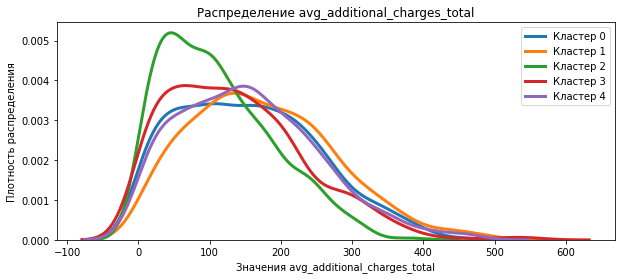

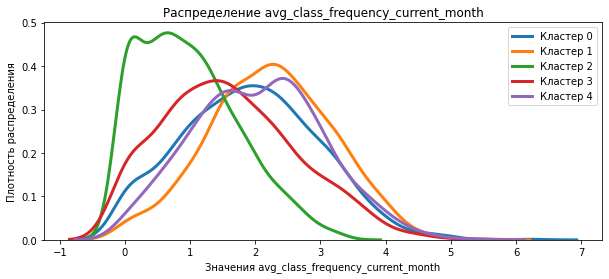

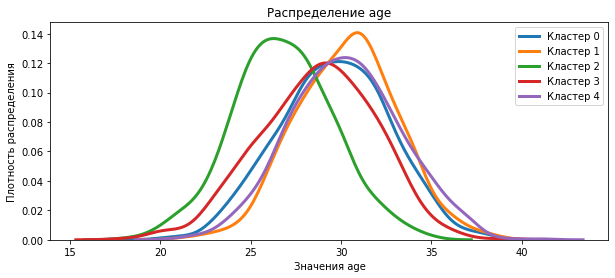

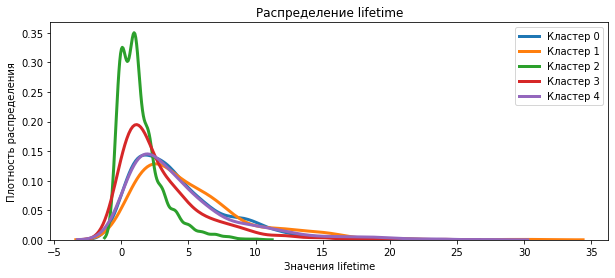

In [23]:
# непрерывные величины в отдельном списке
continuous_new = ['avg_additional_charges_total', 'avg_class_frequency_current_month', 'age', 'lifetime']
# вывод графиков
for col in continuous_new:
    plt.figure(figsize=(10,4))
    for i in range(0,5):
        plt.title(f"Распределение {col}")
        sns.distplot(data.query('cluster == @i')[col],
                     hist=False,
                     kde_kws={'label':'Кластер'+' '+str(i), 'lw':3})
    plt.xlabel(f"Значения {col}")
    plt.ylabel('Плотность распределения')
    plt.legend()
plt.show()
        

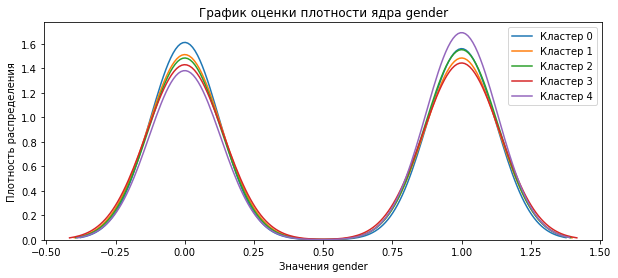

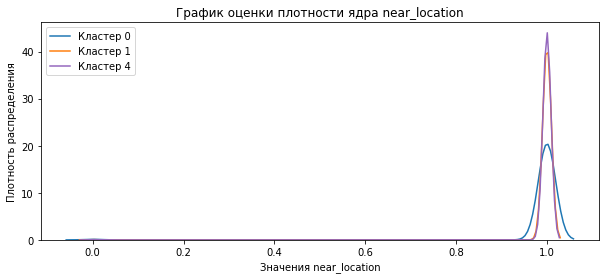

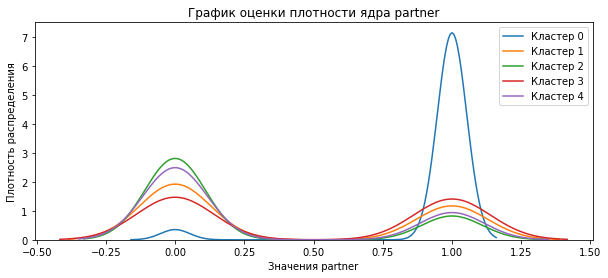

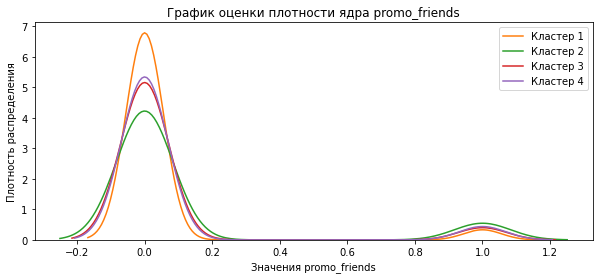

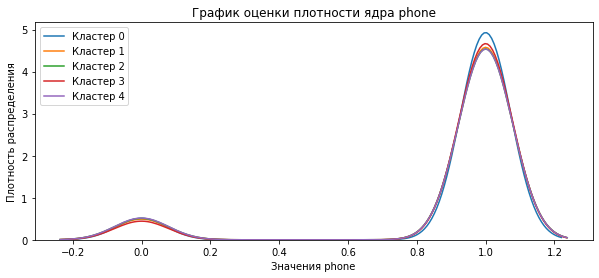

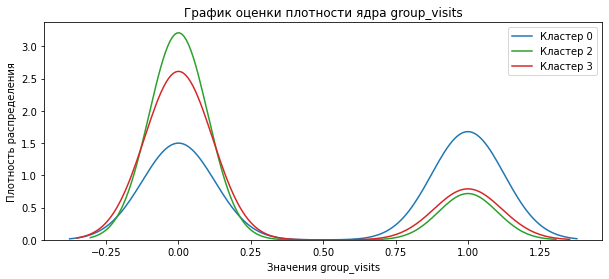

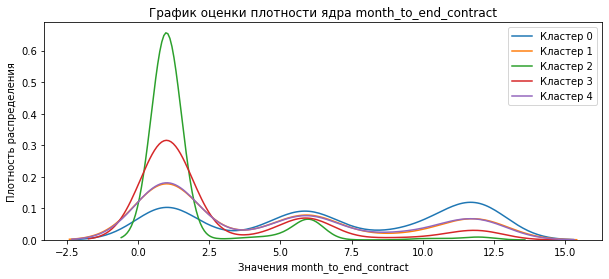

In [24]:
# дискретные величины в отдельном списке
discrete_new = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'month_to_end_contract']
# вывод графиков
for col in discrete_new:
    plt.figure(figsize=(10,4))
    for i in range(0,5):
        plt.title(f"График оценки плотности ядра {col}")
        sns.kdeplot(data.query('cluster == @i')[col], label='Кластер'+' '+str(i))
    plt.xlabel(f"Значения {col}")
    plt.ylabel('Плотность распределения')
    plt.legend()
plt.show()

Графики по сути подтверждают наблюдения указанные в предыдущем пункте. Причем на некоторых графиках, где наблюдается 100% бинарное распределение клиентов, кластер не отобразился (например, на графике для promo_friends, где состоят все клиенты сегмента 0). Это легко подтверждается столбчатой диаграммой.

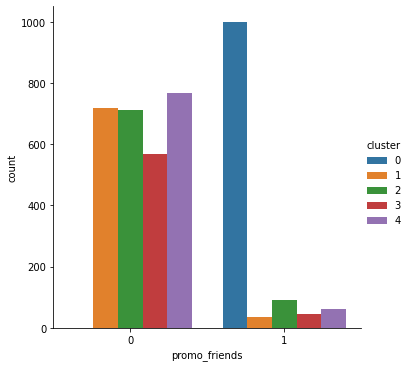

In [25]:
sns.catplot(data=data, x='promo_friends', hue='cluster', kind='count')
plt.show()

## Выводы и рекомендации
<a id="conclusion"></a>
Было проведено исследование признаков клиентской базы сети фитнес-центров и их влияния на отток.
Выводы по исследованию:
1. Отток в последнем месяце достаточно большой - 26.5%.
2. Такие признаки как пол клиента и наличие номера телефона в базе, меньше всего оказывают влияние на отток, и никак не выделяются при сегментации клиентов.
3. Для прогноза оттока клиентов была выбрана модель случайного леса (RandomForestClassifier). Ее доля правильных ответов 91% на валидационной выборке.
4. Наибольшее влияние на отток согласно выбранной модели оказывают признаки:
* время с момента первого обращения в фитнес-центр (вес 32%),
* средняя частота посещений в неделю за предыдущий месяц (вес 21%),
* возраст (вес 14%),
* суммарная выручка от других услуг (вес 12%),
* срок до окончания абонемента (вес 12%).

    Вклад от остальных признаков несущественный.

5. После кластеризации клиентов выделили 5 групп. Наибольший отток по 2-ум кластерам:
* Кластеру 2 (отток 74%): в этом кластере самый молодой средний возраст (27 лет), клиенты там меньше тратят на доп. услуги клуба, пришли в клуб недавно, договор на посещения закончится меньше чем через 2 мес., посещение в среднем 1 раз в неделю.
* Кластер 3 (отток 40%), люди которые живут не близко с клубом и ходят в клуб менее 2-ух раз в неделю в среднем.

    По кластеру 2 видим полное совпадение наиболее влияющих признаков с тем, что определили через модель предсказания выше.
    
Рекомендации по взаимодействию с клиентами и их удержанию:
1. Присылать напоминания на телефон о том, как хорошо заниматься в клубе или о новых возможностях, если клиент ходит менее 2-ух раз в неделю в последний месяц.
2. Продумать систему скидок для тех, кто ходит в клуб от 3-6 месяцев, например.
3. Продумать накопительную систему бонусных баллов для того, чтоб стимулировать покупку доп. услуг. 
4. Присылать напоминания на телефон, стимулирующие продление договора, если срок окончания текущего договора менее 2 мес.